In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, ToPILImage, Lambda
import matplotlib.pyplot as plt
import math

import pandas as pd
from torchvision.io import read_image

In [2]:
class CosmosimImageDataset(Dataset):
    def __init__(self, root, annotations_filename='labels.csv', img_dir='images', train=True, transform=None, target_transform=None):
        df = pd.read_csv('{0}/{1}'.format(root.rstrip('/'), annotations_filename.lstrip('/')))
        if train:
            self.img_labels = df.head(math.floor(0.8 * len(df)))
        else:
            self.img_labels = df.tail(len(df) - math.floor(0.8 * len(df)))
        self.img_dir = '{0}/{1}'.format(root.rstrip('/'), img_dir.lstrip('/'))
        self.transform = transform
        self.target_transform = target_transform
        self.classes = list(self.img_labels.iloc[: , 1:].columns)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        labels = self.img_labels.iloc[idx, 1:]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)
        return image.float(), labels.float()

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100*100, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 15)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: \n, Avg loss: {test_loss:>8f} \n")

In [5]:
root = "__local/data/Cosmosim/3"
training_data = CosmosimImageDataset(
    root=root,
    train=True,
    transform=Lambda(lambda y: ToTensor()(ToPILImage()(y))),
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)

test_data = CosmosimImageDataset(
    root=root,
    train=False,
    transform=Lambda(lambda y: ToTensor()(ToPILImage()(y))),
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)

In [6]:
training_data.img_labels

,name,r_ein,rdsf_l,r_eff_l,x_l,y_l,ellx_l,elly_l,int_l,rdsf_s,r_eff_s,x_s,y_s,ellx_s,elly_s,int_s
0,rs630d.png,2.700346,0.630244,0.522972,0.398216,0.997327,-0.202478,-0.489210,1.756340,1.861811,1.054554,0.370752,-0.735642,-0.490654,0.163257,0.196765
1,pwoys5.png,1.040390,0.652896,0.296470,-0.176169,0.442868,-0.383635,-0.397673,1.878683,1.609817,1.232399,0.971206,0.665363,0.094287,-0.200016,1.411727
2,371xji.png,1.658887,0.431764,0.703276,0.550884,0.787628,-0.064749,-0.194235,0.723728,1.643835,0.552936,0.883643,0.719822,0.471245,-0.390719,1.343119
3,4r45op.png,1.960876,0.634213,1.423436,0.049693,-0.642828,-0.277502,0.262776,0.780389,2.032299,0.218252,-0.050063,0.509541,0.114068,-0.172871,0.268468
4,2qxz59.png,1.178198,0.634001,1.939602,-0.850952,-0.248208,-0.153294,-0.104219,1.267755,2.167519,0.471092,0.934007,0.170691,-0.128821,0.432726,1.890228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,rj8s65.png,2.727041,0.472886,0.470485,-0.038206,-0.428009,0.233163,0.192727,0.389057,1.939587,0.616539,-0.405394,0.014120,-0.364454,-0.481205,1.627000
799996,ydpjsd.png,1.428723,0.509985,0.260494,-0.744679,-0.875194,-0.183541,0.236157,0.385675,2.433002,0.224397,0.895485,0.793043,0.204369,0.379925,1.729253
799997,0jxdc7.png,2.511083,0.414040,1.457853,0.529289,0.307390,0.285397,0.453578,1.323044,1.635725,0.778038,-0.342167,-0.801914,-0.338304,-0.343061,1.596066
799998,khhnph.png,2.547339,0.678396,1.185161,0.170930,0.882201,0.483728,0.401745,1.505382,1.650023,1.002196,0.247376,0.150169,-0.167980,-0.263568,1.005437


In [7]:
test_data.img_labels

,name,r_ein,rdsf_l,r_eff_l,x_l,y_l,ellx_l,elly_l,int_l,rdsf_s,r_eff_s,x_s,y_s,ellx_s,elly_s,int_s
800000,fekdep.png,1.061661,0.458293,1.302127,0.052242,0.038453,0.237662,-0.313771,0.453388,1.653257,1.223223,-0.859437,0.145567,-0.041482,-0.227989,1.161082
800001,xx93q2.png,1.789608,0.460561,1.141660,-0.160405,0.444119,-0.476114,-0.146151,0.633478,1.506536,0.761940,-0.861362,0.603749,0.361041,0.341492,1.665211
800002,kapvmb.png,1.000889,0.432585,0.955505,-0.496312,0.758255,-0.132595,0.073783,0.713665,2.109347,0.689208,-0.493097,0.937069,0.238217,0.189913,0.978894
800003,vf7ckh.png,2.498351,0.540971,1.085142,-0.946483,0.905901,-0.490384,-0.214653,0.408734,2.213251,1.119941,-0.592254,0.761651,-0.351246,0.489428,1.205996
800004,xkwxqs.png,1.202039,0.634256,1.675445,-0.431118,-0.626649,0.147294,0.144052,1.406588,2.258710,1.486144,-0.159648,-0.608411,0.361175,-0.353728,0.533627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0voc76.png,1.276479,0.498948,0.062823,-0.101601,0.073682,0.423387,0.223573,1.187310,2.082496,0.325896,-0.835090,-0.336404,0.347191,0.296764,0.490726
999996,x9i9iv.png,0.907382,0.574434,1.022616,0.074733,0.399242,0.345562,0.175502,1.030597,1.714774,0.432773,-0.129230,-0.083743,0.046568,-0.192266,0.264709
999997,43003n.png,0.699150,0.628239,1.080816,0.601147,-0.056662,0.204330,-0.230291,1.814100,2.425304,0.047576,0.245684,0.318981,0.447049,0.053822,0.221779
999998,vs142a.png,1.700400,0.670966,0.661328,-0.440111,0.417939,0.442442,0.011326,0.707856,2.378885,0.839870,-0.074889,0.859126,0.377918,-0.242165,1.702707


In [8]:
training_data.classes

['r_ein',
 'rdsf_l',
 'r_eff_l',
 'x_l',
 'y_l',
 'ellx_l',
 'elly_l',
 'int_l',
 'rdsf_s',
 'r_eff_s',
 'x_s',
 'y_s',
 'ellx_s',
 'elly_s',
 'int_s']

In [9]:
labels_map = training_data.img_labels.r_ein
labels_map

0         2.700346
1         1.040390
2         1.658887
3         1.960876
4         1.178198
            ...   
799995    2.727041
799996    1.428723
799997    2.511083
799998    2.547339
799999    0.878058
Name: r_ein, Length: 800000, dtype: float64

In [10]:
idx = 0
img, label = training_data[idx]
print(label)

tensor([ 2.7003,  0.6302,  0.5230,  0.3982,  0.9973, -0.2025, -0.4892,  1.7563,
         1.8618,  1.0546,  0.3708, -0.7356, -0.4907,  0.1633,  0.1968])


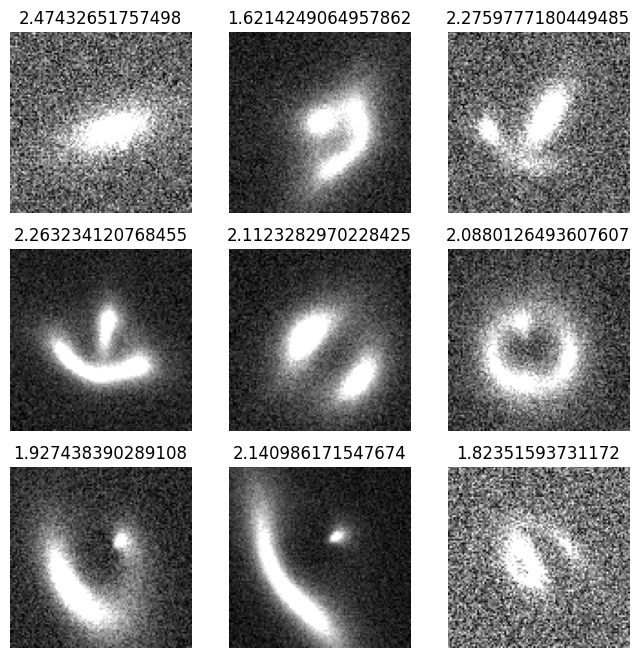

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[sample_idx])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [12]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 100, 100])
Labels batch shape: torch.Size([64, 15])


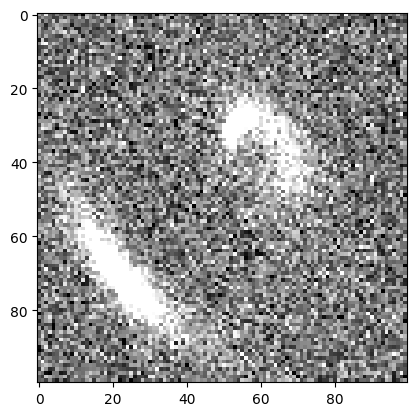

Label: tensor([ 2.9984,  0.4191,  1.4569,  0.8538,  0.2657, -0.3439, -0.2953,  0.0468,
         1.5448,  0.7105, -0.5024, -0.4321, -0.4573, -0.1639,  0.8197])


In [13]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [15]:
model = NeuralNetwork().to(device)

In [16]:
learning_rate = 1e-3
epochs = 10

In [17]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.075785  [   64/800000]
loss: 0.073918  [ 6464/800000]
loss: 0.071451  [12864/800000]
loss: 0.075934  [19264/800000]
loss: 0.066243  [25664/800000]
loss: 0.069501  [32064/800000]
loss: 0.073335  [38464/800000]
loss: 0.063670  [44864/800000]
loss: 0.073382  [51264/800000]
loss: 0.075480  [57664/800000]
loss: 0.080304  [64064/800000]
loss: 0.070844  [70464/800000]
loss: 0.067130  [76864/800000]
loss: 0.068735  [83264/800000]
loss: 0.071393  [89664/800000]
loss: 0.065400  [96064/800000]
loss: 0.067670  [102464/800000]
loss: 0.066464  [108864/800000]
loss: 0.089332  [115264/800000]
loss: 0.070757  [121664/800000]
loss: 0.066154  [128064/800000]
loss: 0.071246  [134464/800000]
loss: 0.076484  [140864/800000]
loss: 0.062715  [147264/800000]
loss: 0.068845  [153664/800000]
loss: 0.080334  [160064/800000]
loss: 0.066931  [166464/800000]
loss: 0.068359  [172864/800000]
loss: 0.066465  [179264/800000]
loss: 0.074747  [185664/800000]
loss: 0.073238  

In [21]:
torch.save(model.state_dict(), '__local/models/model_customnet_1_e20.pth')